# 0.0 - IMPORTS

In [1]:
import math
import random
import pickle
import warnings
import datetime
import inflection

import pandas  as pd
import numpy   as np
import seaborn as sns
import xgboost as xgb

from scipy      import stats   as ss
from matplotlib import pyplot  as plt
from matplotlib import patches as mpatches

from IPython.core.display  import HTML
from IPython.display       import Image
from boruta                import BorutaPy
from matplotlib.gridspec   import GridSpec
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1 - Helper Funcions

In [2]:
def cramer_v(x,y):
    cm = pd.crosstab(x, y).values
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    (r, k) = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)
    
    return np.sqrt((chi2corr / n) / (min(kcorr-1, rcorr-1)))


def jupyter_settings():
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container{width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()

    
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((yhat / y) - 1))
    
    
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])


def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in range(kfold, 0, -1):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        
        # start and end date of validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k * 6 * 7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1) * 6 * 7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training and validation datasets
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat_m = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat_m))

        # storing performance
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])

## 0.2 - Settings

In [3]:
jupyter_settings()
pd.set_option('mode.chained_assignment', None)
warnings.filterwarnings('ignore')

## 0.3 - Load Data

In [4]:
# Loading data from each day of sales  
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False )

# Loading dataset of attributes for each store  
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False )

# Merging the two  
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0 - DESCRIPTIVE DATA ANALYSIS

In [5]:
# Creating a copy of the dataset resulting from the last block.  
# This saves time if the dataset gets messed up by some operation.  
df1 = df_raw.copy()

## 1.1 - Renaming Columns

In [6]:
cols_old = [ 'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval' ]

# Creating a lambda function for converting strings into snakecase format.  
snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

df1.columns = cols_new

## 1.2 - Data Dimension

In [7]:
print('Temos {} linhas e {} colunas.'.format(df1.shape[0], df1.shape[1]))

Temos 1017209 linhas e 18 colunas.


## 1.3 - Data Types

In [8]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

### 1.3.1 - Fixing Data Types

In [9]:
# We can see that the date column is a string rather than a datetime.  
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 - Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 - Fillout NA

In [11]:
# competition_distance              2642

# We'll assume that a NA value means that there is no close competition.  
# We can replace it for an arbitrary large value, much bigger than the column maximum.  

df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

# competition_open_since_month    323348
# competition_open_since_year     323348

# Reasons can be: there is no close competitor  
#                 we have no data for when the competitor has opened.  
# In both cases, we can say that the competitor has opened in the same day as the referring sales data.  
# This gives us a zeroed result for the question "how long has the competition been there".  
# If there competition is open for the last 0 days, we can say that it did not affect the sales,  
# and that is what we want in both possible cases.  

df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

# promo2_since_week               508031
# promo2_since_year               508031

# We'll assume that, for these dates we have no promotion.
# Similarly to the previous column we have analised, we can say that
# the promotion has started in the day of the referring sales data.

df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

# promo_interval                  508031

# Here we will assume that this means that there is no  
# promotion during the year.  
# We will create a new column that maps if the store was in
# promotion at the time of the sale.

map_month = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

df1['promo_interval'].fillna( 0, inplace=True )

df1['map_month'] = df1['date'].dt.month.map( map_month )

df1['is_promo'] = df1[['map_month', 'promo_interval']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['map_month'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [12]:
df1.isna().sum()

# solved!  

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
map_month                       0
is_promo                        0
dtype: int64

## 1.6 - Check Data Types

In [13]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
map_month                               object
is_promo                                 int64
dtype: object

In [14]:
# These columns were inserted as floats, but they can serve their purpose better as ints.  

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7 - Desctiptive Statistics

In [15]:
# Creating separate dataframes for different types of data

num_attr = df1.select_dtypes( include=['int64', 'float64'] )
cat_attr = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 - Numerical Attributes


In [16]:
# Central Tendency Metrics - mean, median
ct1 = pd.DataFrame( num_attr.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attr.apply( np.median ) ).T

# Dispersion Metrics
d1 = pd.DataFrame( num_attr.apply( np.std ) ).T
d2 = pd.DataFrame( num_attr.apply( min ) ).T
d3 = pd.DataFrame( num_attr.apply( max ) ).T
d4 = pd.DataFrame( num_attr.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attr.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attr.apply( lambda x: x.kurtosis() ) ).T

# Concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attribute', 'min', 'max', 'range', 'mean', 'median', 'std', 'skewness', 'kurtosis']

m

attribute     min       max     range         mean  median           std   skewness    kurtosis
0                          store     1.0    1115.0    1114.0   558.429727   558.0    321.908493  -0.000955   -1.200524
1                    day_of_week     1.0       7.0       6.0     3.998341     4.0      1.997390   0.001593   -1.246873
2                          sales     0.0   41551.0   41551.0  5773.818972  5744.0   3849.924283   0.641460    1.778375
3                      customers     0.0    7388.0    7388.0   633.145946   609.0    464.411506   1.598650    7.091773
4                           open     0.0       1.0       1.0     0.830107     1.0      0.375539  -1.758045    1.090723
5                          promo     0.0       1.0       1.0     0.381515     0.0      0.485758   0.487838   -1.762018
6                 school_holiday     0.0       1.0       1.0     0.178647     0.0      0.383056   1.677842    0.815154
7           competition_distance    20.0  200000.0  199980.0  5935.442677  2330.0  12547.646829  10.242344  147.789712
8   competition_open_since_month     1.0      12.0      11.0     6.786849     7.0      3.311085  -0.042076   -1.232607
9    competition_open_since_year  1900.0    2015.0     115.0  2010.324840  2012.0      5.515591  -7.235657  124.071304
10                        promo2     0.0       1.0       1.0     0.500564     1.0      0.500000  -0.002255   -1.999999
11             promo2_since_week     1.0      52.0      51.0    23.619033    22.0     14.310057   0.178723   -1.184046
12             promo2_since_year  2009.0    2015.0       6.0  2012.793297  2013.0      1.662657  -0.784436   -0.210075
13                      is_promo     0.0       1.0       1.0     0.171835     0.0      0.377237   1.739838    1.027039

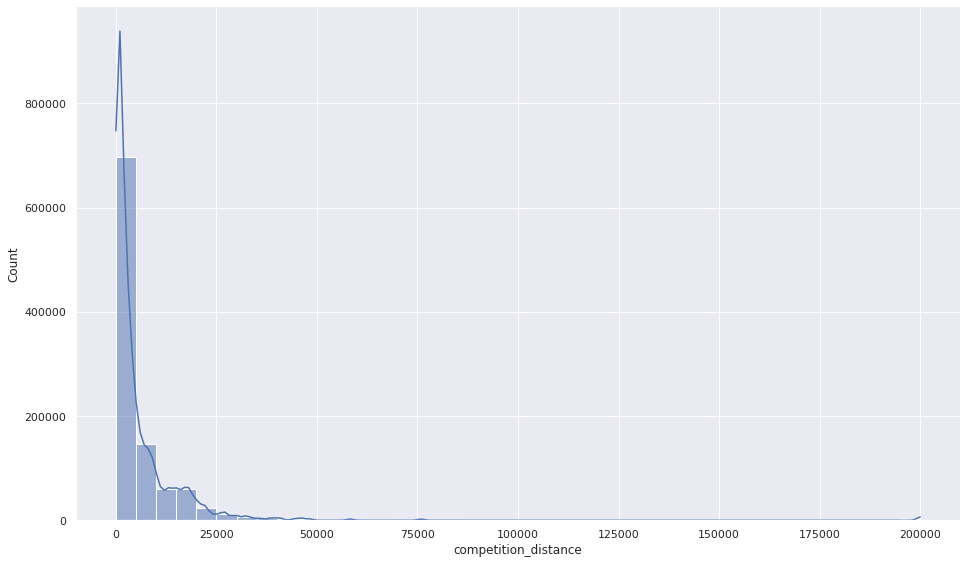

In [17]:
# Plotting some data for analysis.  

sns.displot(df1['competition_distance'], height=8, aspect=1.7, kde=True, bins=40);

### 1.7.2 - Categorical Attributes

In [18]:
# Let's see how many categories are there for each categorical attribute.

cat_attr.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
map_month         12
dtype: int64

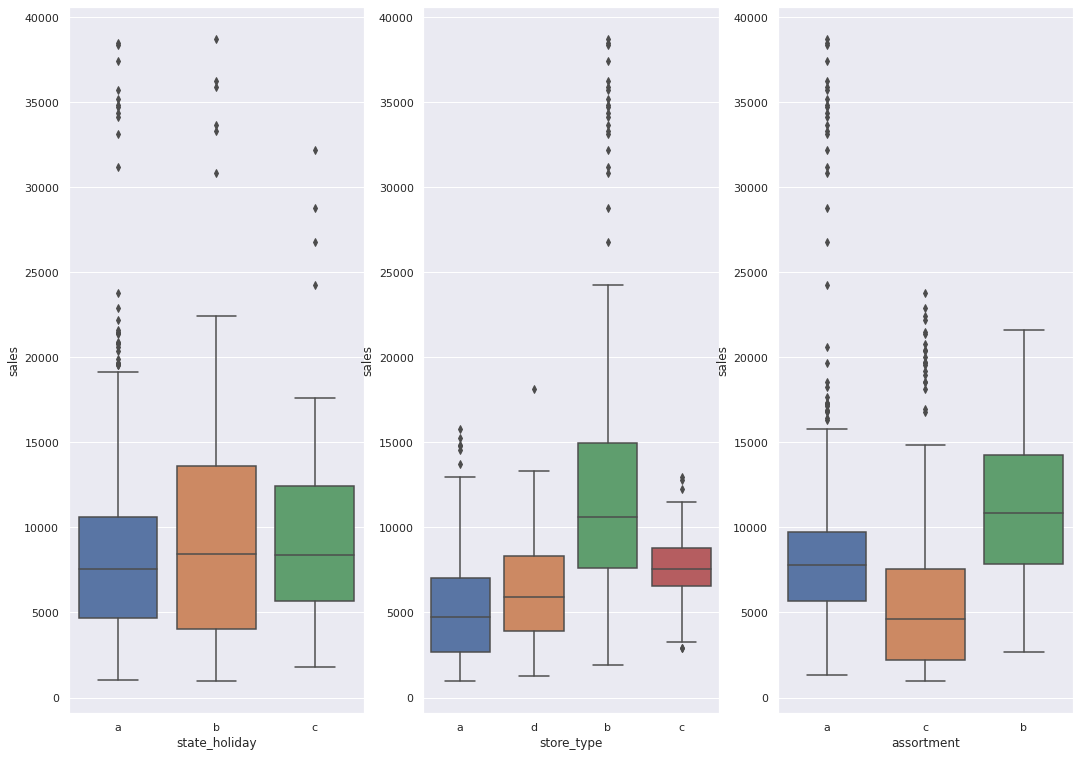

In [19]:
# We can visualize these data in the for of box plots.  

aux1 = df1.loc[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(18, 13))

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1);

# 2.0 - FEATURE ENGINEERING

In [20]:
df2 = df1.copy()

## 2.1 - Creating Hypotheses

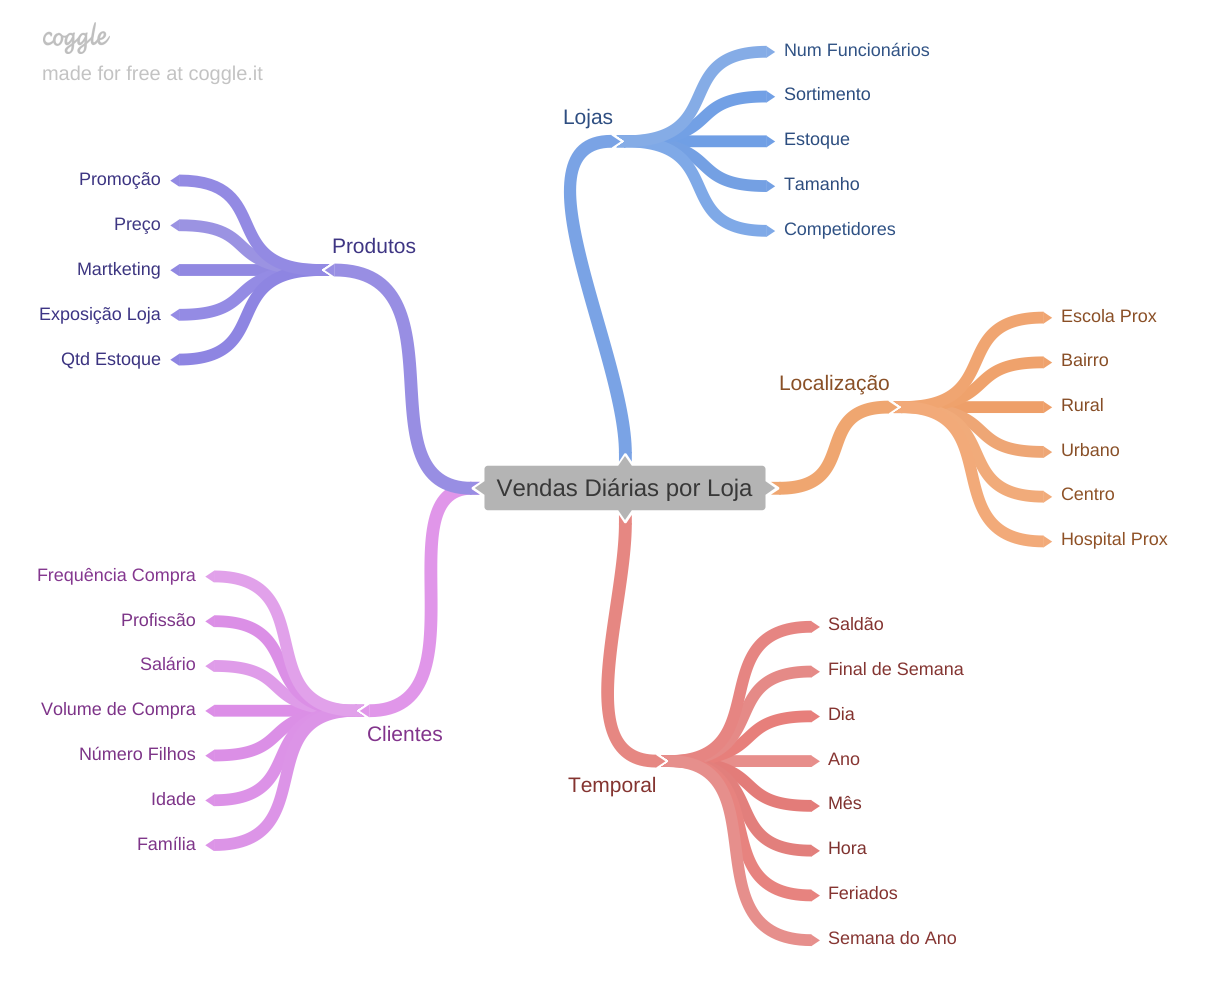

In [21]:
# Hypotesis Mind Map
Image('img/hypothesis_mind_map.png')

### 2.1.1 - Store Related Hypotheses

**1.** Stores with more employees should sell more.

**2.** Stores with a bigger stock should sell more.

**3.** Bigger stores should sell more.

**4.** Stores with nearby competitors for longer should sell more.

**5.** Stores with more diversity of stock should sell more.

**6.** Stores with more competitors nearby should sell less.

### 2.1.2 - Product Relates Hypotheses

**1.** Stores that invest more in marketing should sell more.

**2.** Stores with more exposed products should sell more.

**3.** Stores with lower prices should sell more.

**4.** Stores with lower prices for longer should sell more.

**5.** Stores with aggressive promotions should sell more.

**6.** Stores with more promotion days should sell more.

**7.** Stores with more consecutive promotions should sell more.

### 2.1.3 - Time Related Hypotheses

**1.** Stores should sell less in school holidays.

**2.** Stores should sell more during the second semester.

**3.** Stores should sell less in weekends.

**4.** Stores that open during holidays should sell more.

**5.** Stores should increase sales along the years.

**6.** Stores should sell more after the 10th of each month.

## 2.2 - Final Hypotheses List

**1.** Stores with more diverse storage should sell more.

**2.** Stores with more competitors nearby should sell less.

**3.** Stores with near competition for longer should sell more.

**4.** Stores with active promotion for longer should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores that open during holidays should sell more.

**8.** Stores should increase sales along the years.

**9.** Stores should sell more during the second semester.

**10.** Stores should sell more after the 10th of each month.

**11.** Stores should sell less in weekends.

**12.** Stores should sell less in school holidays.

## 2.3 - Feature Engineering

In [22]:
# FROM DATE:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# change to better values:
# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0 - VARIABLE FILTERING

In [23]:
df3 = df2.copy()

## 3.1 - Rows Filtering

In [24]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 - Column Selection

In [25]:
cols_drop = ['customers', 'open', 'promo_interval', 'map_month']
df3 = df3.drop(cols_drop, axis=1)

# 4.0 - EXPLORATORY DATA ANALYSIS

In [26]:
df4 = df3.copy()

## 4.1 - Univariate Analysis

### 4.1.1 - Response Variable

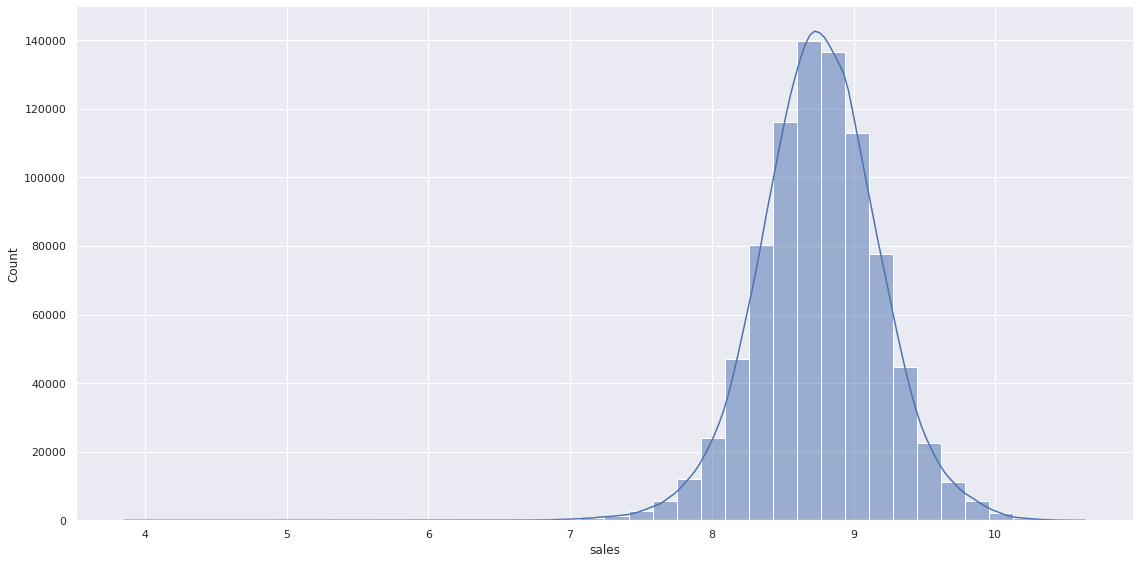

In [27]:
sns.displot(np.log1p(df4['sales']), kde=True, height=8, aspect=2, bins=40);

### 4.1.2 - Numerical Variables

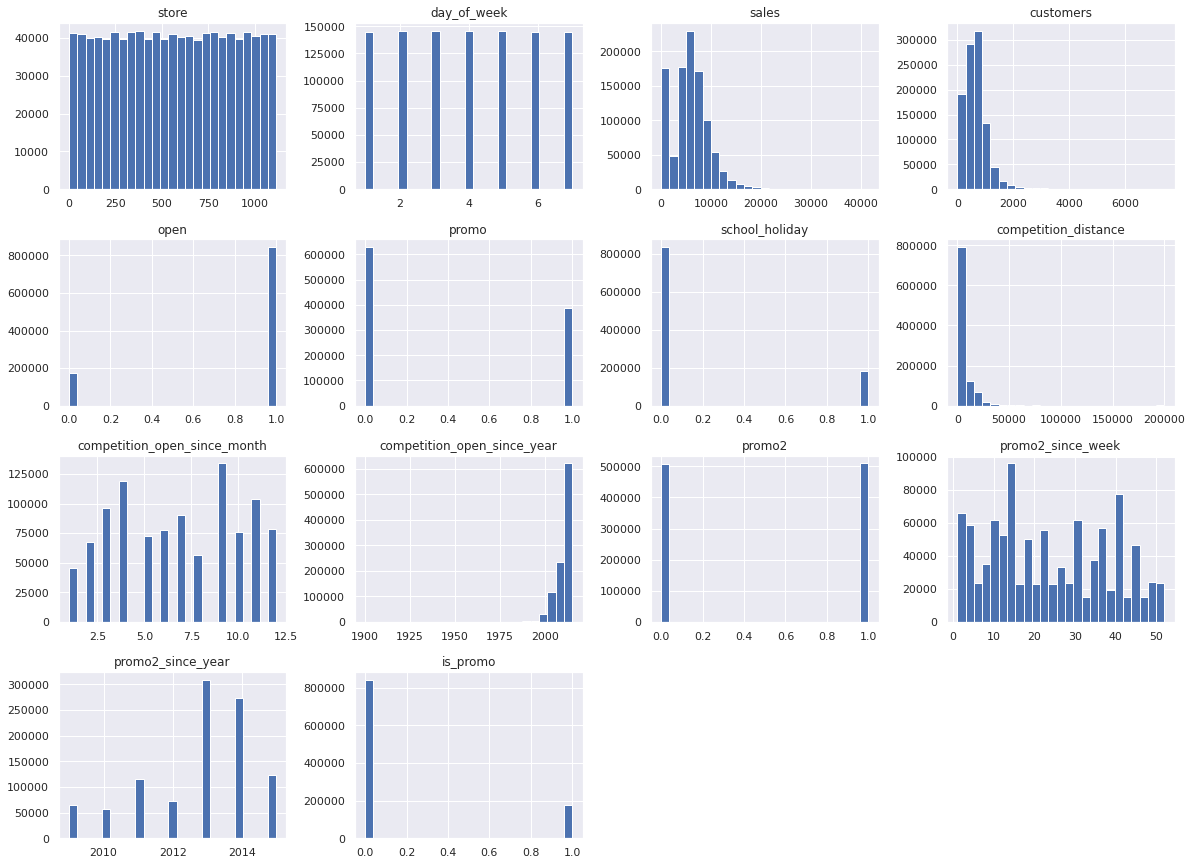

In [28]:
num_attr.hist(bins=25, figsize=(20,15));

In [29]:
# 'store'                           not much variability. needed to identify store.
# 'day_of_week'                     no variability, but can be useful paired with others.
# 'sales'                           our response variable. rather log-normal distribution.
# 'customers'                       lots of vatiability. similar to sales. should explain a lot, but can't be used in predictions.
# 'open'                            only 2 values, one which is disposable. no info.
# 'promo'                           only 2 values, should help us a lot.
# 'school_holiday'                  only 2 values, should help us a lot.
# 'competition_distance'            very dense near zero. might be an extreme poisson case.
# 'competition_open_since_month'    
# 'competition_open_since_year'     very dense near 2010. expectable.
# 'promo2'                          
# 'promo2_since_week'
# 'promo2_since_year'               a lot of variability on a really influential piece of data. should be very useful.
# 'is_promo'

### 4.1.3 - Categorical Variables

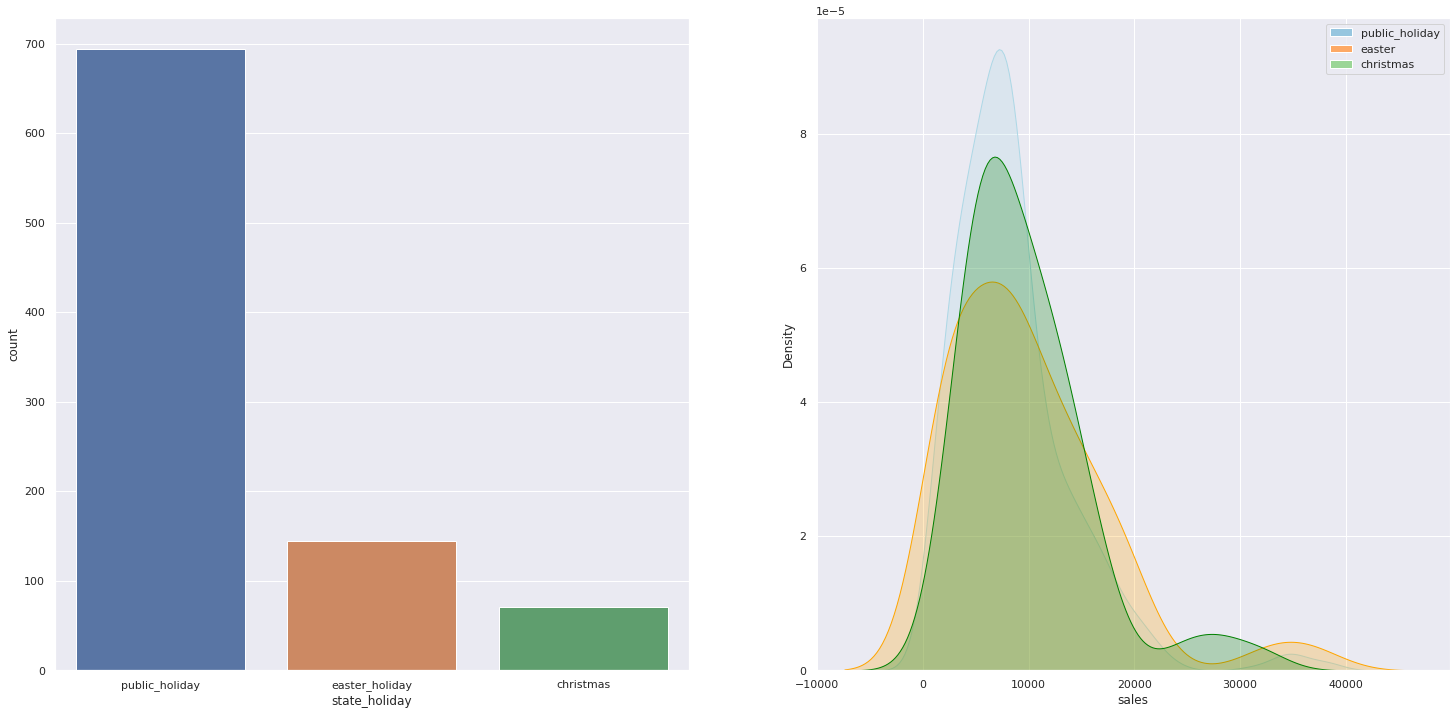

In [30]:
#'state_holiday', 'store_type', 'assortment', 'promo_interval'

plt.subplot(1, 2, 1)
sns.countplot(x=df4[df4['state_holiday'] != 'regular_day']['state_holiday'])

plt.subplot(1, 2, 2)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'], shade=True, cmap='Blues', color='lightblue');
sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'], shade=True, cmap='Oranges', color='orange');
sns.kdeplot(df4[df4['state_holiday']=='christmas']['sales'], shade=True, cmap='Greens', color='green');

handles = [mpatches.Patch(facecolor=plt.cm.Blues(100), label='public_holiday'),
           mpatches.Patch(facecolor=plt.cm.Oranges(100), label='easter'),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label='christmas')]

plt.legend(handles=handles);

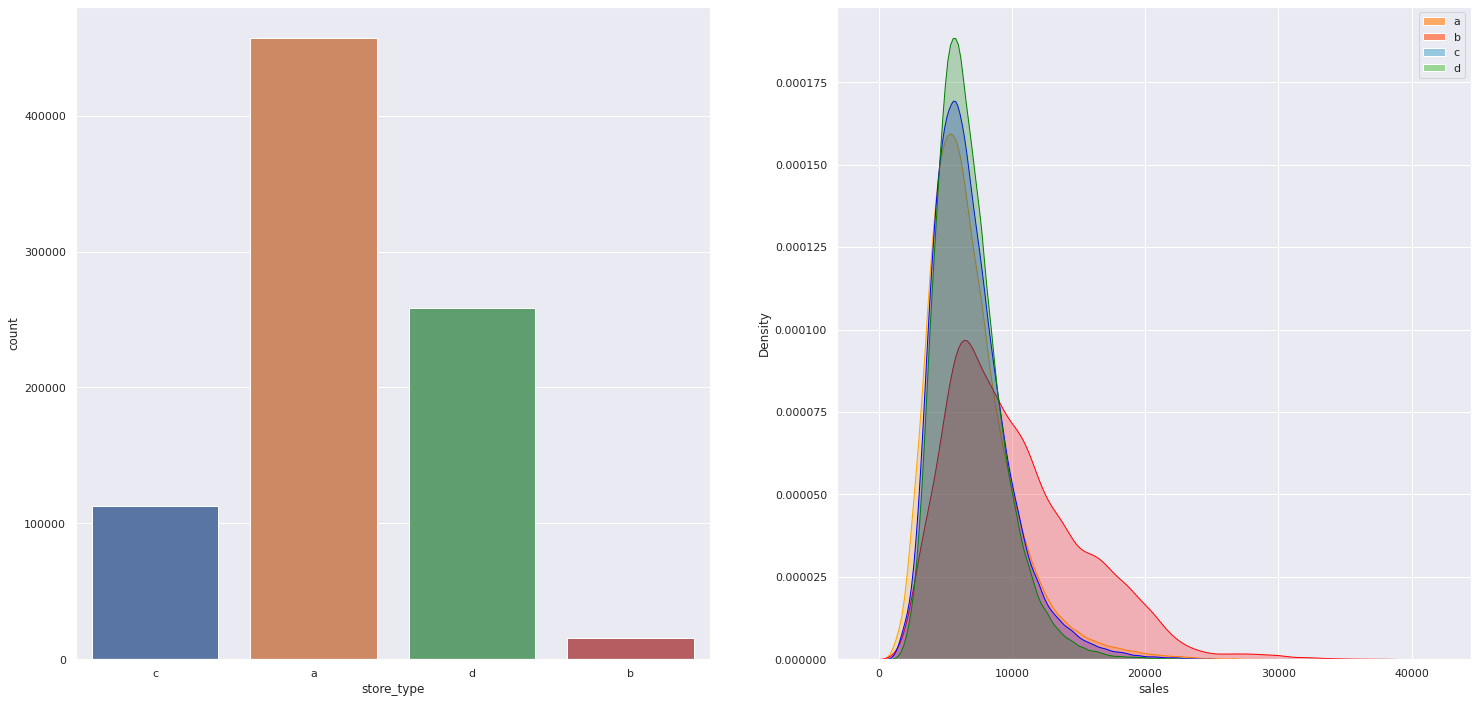

In [31]:
plt.subplot(1, 2, 1)
sns.countplot(x=df4['store_type'])

plt.subplot(1, 2, 2)
sns.kdeplot(df4[df4['store_type']=='a']['sales'], shade=True, cmap='Oranges', color='orange');
sns.kdeplot(df4[df4['store_type']=='b']['sales'], shade=True, cmap='Reds', color='red');
sns.kdeplot(df4[df4['store_type']=='c']['sales'], shade=True, cmap='Blues', color='blue');
sns.kdeplot(df4[df4['store_type']=='d']['sales'], shade=True, cmap='Greens', color='green');

handles = [mpatches.Patch(facecolor=plt.cm.Oranges(100), label='a'),
           mpatches.Patch(facecolor=plt.cm.Reds(100), label='b'),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label='c'),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label='d')]
plt.legend(handles=handles);

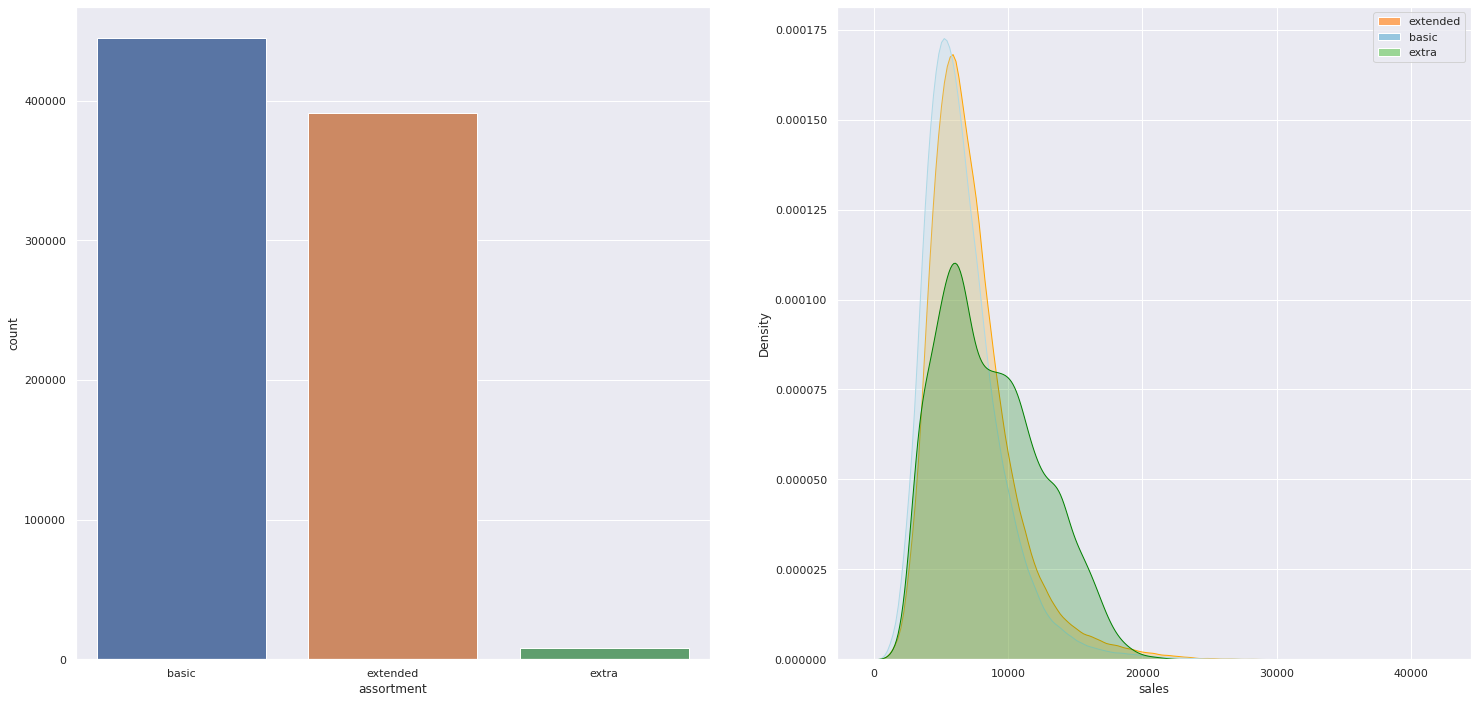

In [32]:
plt.subplot(1, 2, 1)
sns.countplot(x=df4['assortment'])

plt.subplot(1, 2, 2)
sns.kdeplot(df4[df4['assortment']=='extended']['sales'], shade=True, cmap='Oranges', color='orange');
sns.kdeplot(df4[df4['assortment']=='basic']['sales'], shade=True, cmap='Blues', color='lightblue');
sns.kdeplot(df4[df4['assortment']=='extra']['sales'], shade=True, cmap='Greens', color='green');

handles = [mpatches.Patch(facecolor=plt.cm.Oranges(100), label='extended'),
           mpatches.Patch(facecolor=plt.cm.Blues(100), label='basic'),
           mpatches.Patch(facecolor=plt.cm.Greens(100), label='extra')]
plt.legend(handles=handles);

## 4.2 - Bivariate Analysis

### H1. Stores with more diversity of stock should sell more. 
TRUE

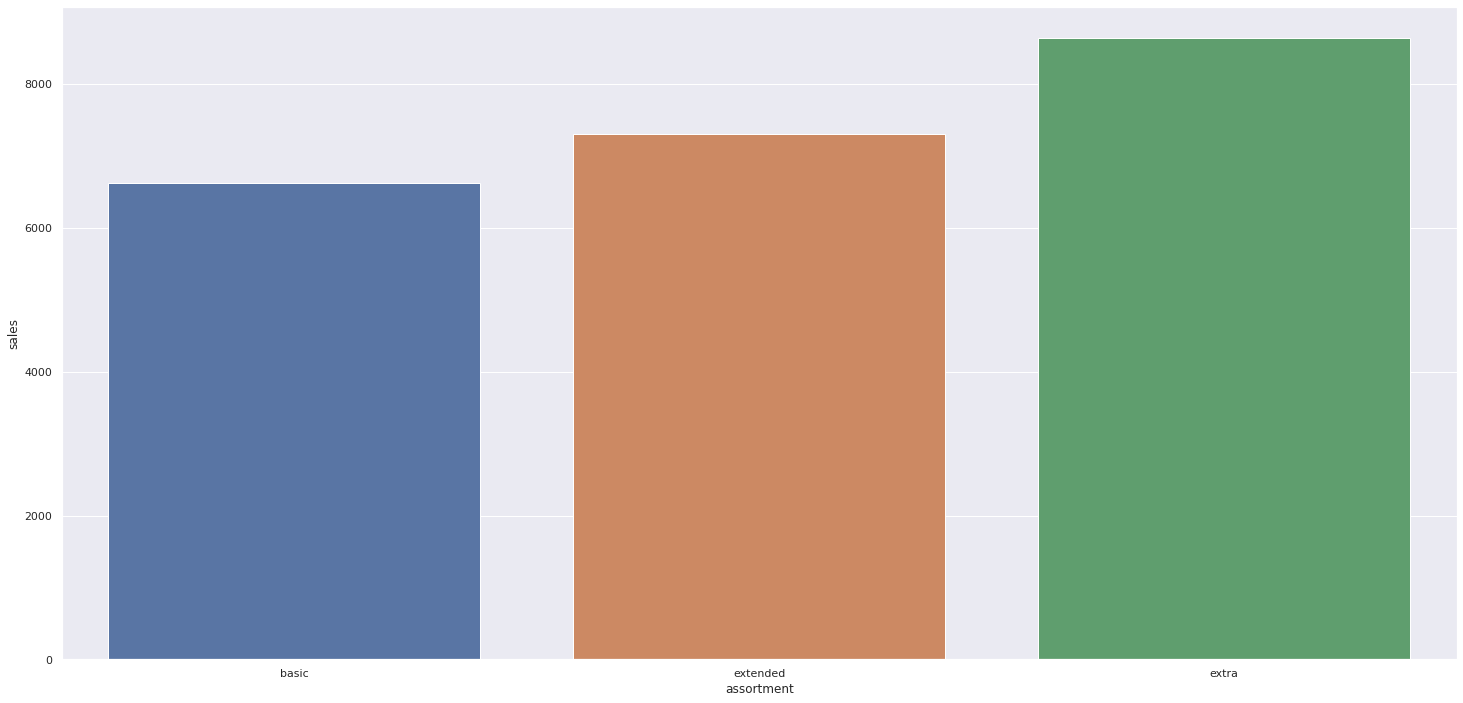

In [33]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
auxi1 = df4[['assortment', 'sales']].groupby('assortment').count().reset_index()
aux1['sales'] = aux1['sales'] / auxi1['sales']

sns.barplot(x='assortment', y='sales', data=aux1);

### H2. Stores with more competitors nearby should sell less.
FALSE

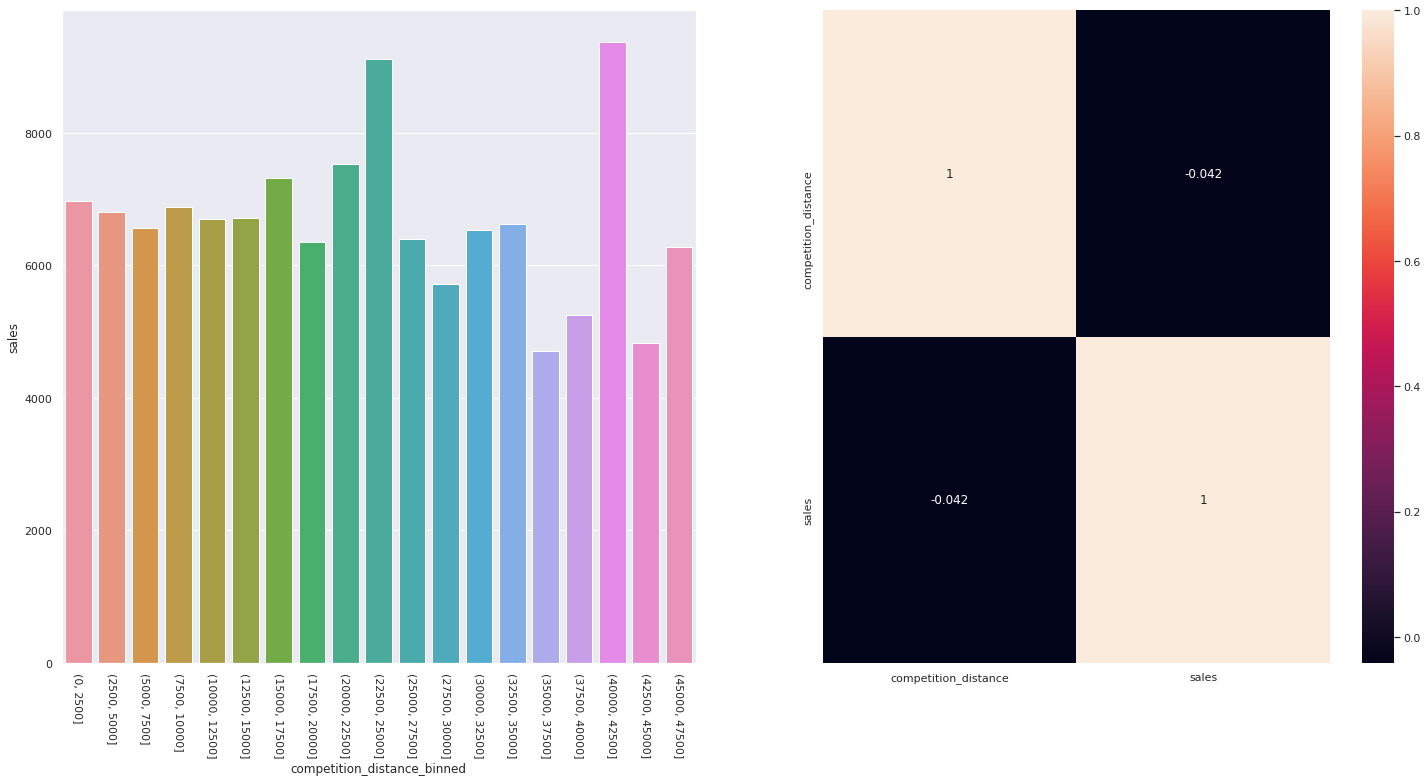

In [34]:
aux2 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
auxi2 = df4[['competition_distance', 'sales']].groupby('competition_distance').count().reset_index()

aux2['sales'] = aux2['sales'] / auxi2['sales']
bins = range(0, 50000, 2500)
aux2['competition_distance_binned'] = pd.cut(aux2['competition_distance'], bins=bins)
auxi2['competition_distance_binned'] = pd.cut(auxi2['competition_distance'], bins=bins)

aux2 = aux2[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
auxi2 = auxi2[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').count().reset_index()
aux2['sales'] = aux2['sales'] / auxi2['sales']

plt.subplot(1, 2, 1)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=270)

plt.subplot(1, 2, 2)
sns.heatmap(df4[['competition_distance', 'sales']].corr(method='pearson'), annot=True);

### H3. Stores with near competition for longer should sell more.
FALSE

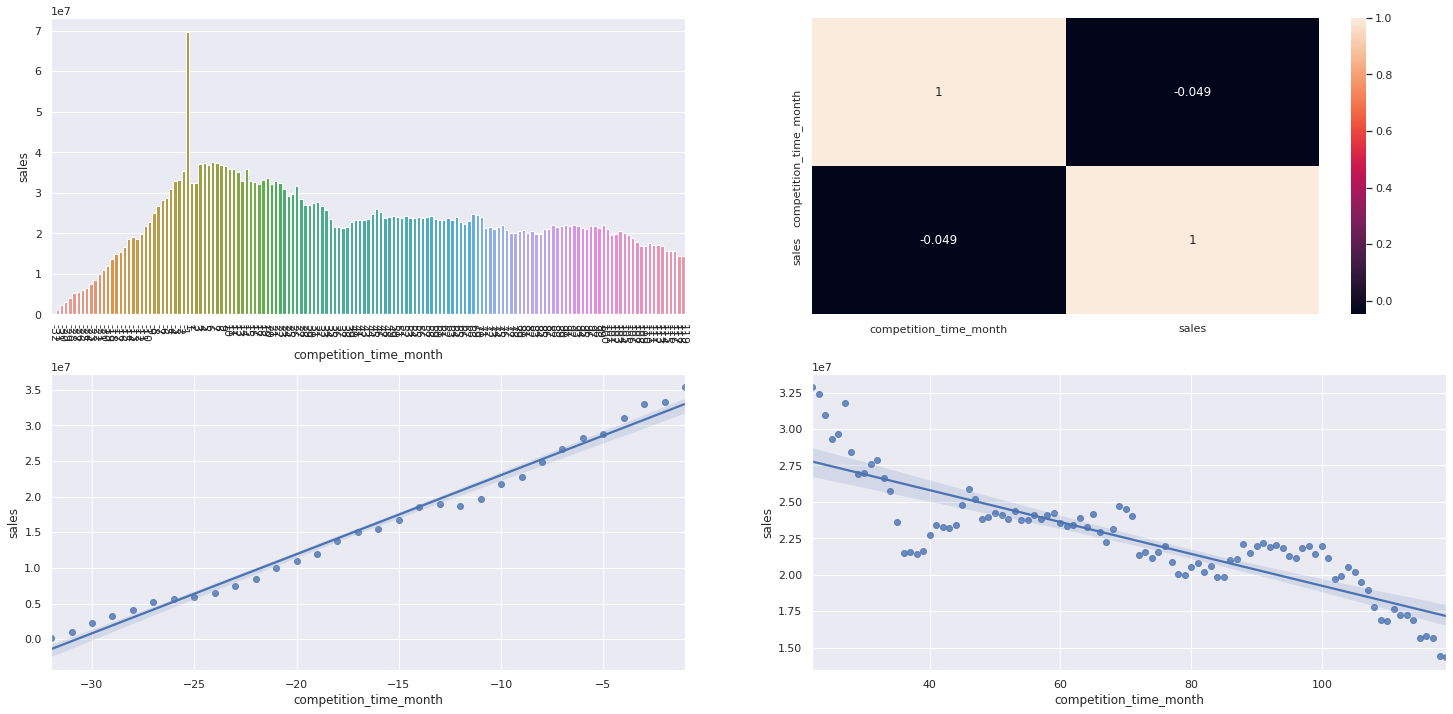

In [35]:
aux3 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux3= aux3[(aux3['competition_time_month'] < 120) & (aux3['competition_time_month'] != 0)]

# barplot
plt.subplot(2, 2, 1)
sns.barplot(x='competition_time_month', y='sales', data=aux3);
plt.xticks(rotation=270);

#heatmap
plt.subplot(2, 2, 2)
sns.heatmap(aux3.corr(method='pearson'), annot=True);

# tendency in negative values
plt.subplot(2, 2, 3)
sns.regplot(x='competition_time_month', y='sales', data=aux3[aux3['competition_time_month'] < 0]);

# tendency for positive values
plt.subplot(2, 2, 4)
sns.regplot(x='competition_time_month', y='sales', data=aux3[aux3['competition_time_month'] > 21]);

### H4. Stores with active promotion for longer should sell more.
FALSE: Sells regularly for a while, then sales drop.

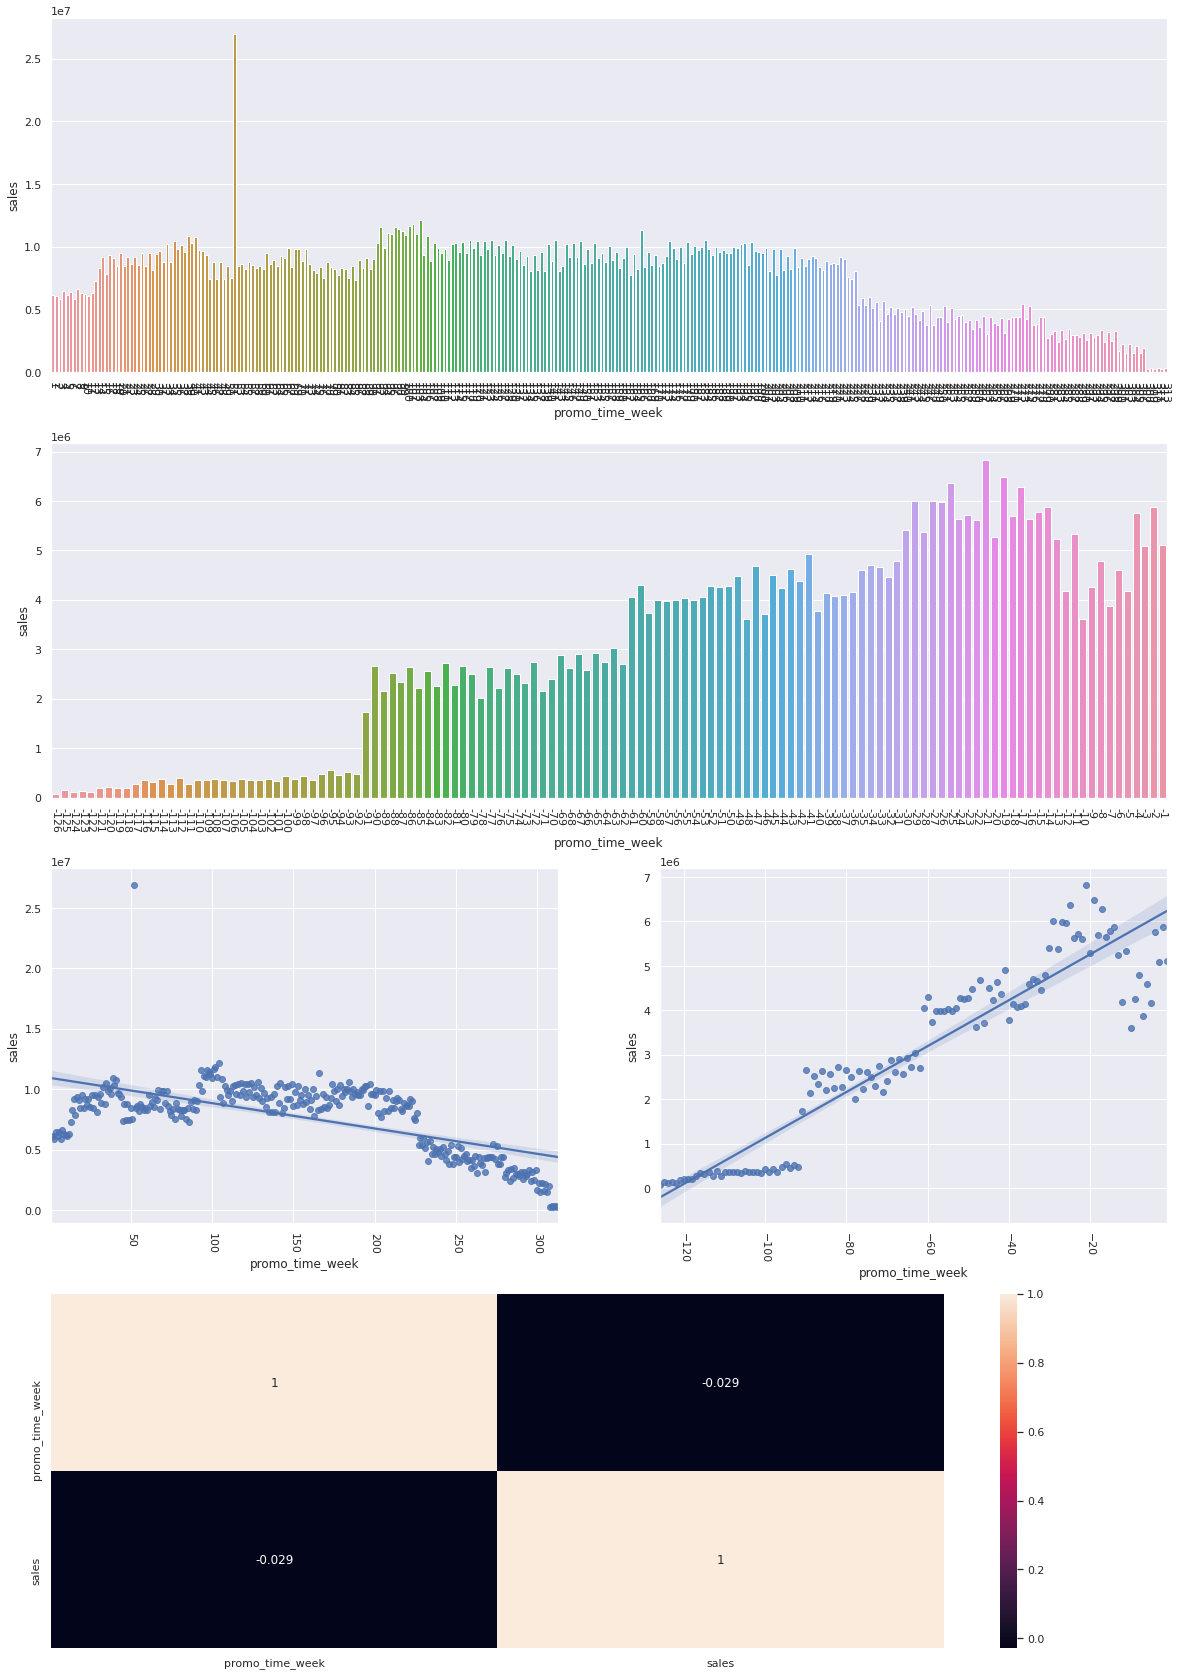

In [36]:
aux4 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()
auxpos = aux4[aux4['promo_time_week'] > 0]
auxneg = aux4[aux4['promo_time_week'] < 0]

grid = GridSpec(4, 2)

plt.figure(figsize=(20, 30))
plt.subplot(grid[0, :])
sns.barplot(x='promo_time_week', y='sales', data=auxpos)
plt.xticks(rotation=270);

plt.subplot(grid[1, :])
sns.barplot(x='promo_time_week', y='sales', data=auxneg)
plt.xticks(rotation=270);

plt.subplot(grid[2, 0])
sns.regplot(x='promo_time_week', y='sales', data=auxpos)
plt.xticks(rotation=270);

plt.subplot(grid[2, 1])
sns.regplot(x='promo_time_week', y='sales', data=auxneg)
plt.xticks(rotation=270);

plt.subplot(grid[3, :])
sns.heatmap(aux4.corr(method='pearson'), annot=True);

### <s>H5. Stores with more promotion days should sell more.</s>


### H6. Stores with more consecutive promotions should sell more.
FALSE

In [37]:
aux6 = df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

auxi6 = df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).count().reset_index()

aux6['sales'] = aux6['sales'] / auxi6['sales']

aux6

promo  promo2        sales
0      0       0  6328.187633
1      0       1  5529.566684
2      1       0  8618.452062
3      1       1  7836.672987

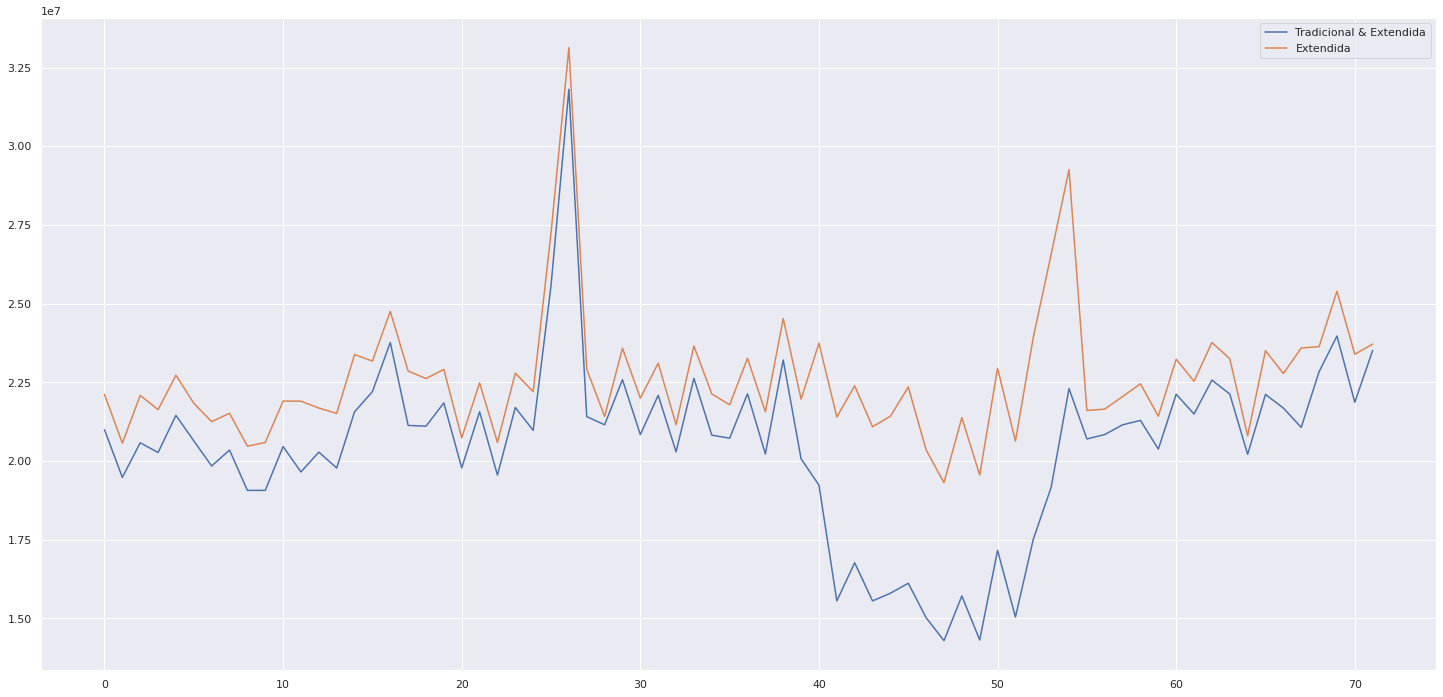

In [38]:
auxil6 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = auxil6.plot();

auxil6 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
auxil6.plot(ax=ax);

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);

### H7. Stores that open during Christmas should sell more.
FALSA: Ocurred in 2014, but not in 2013.

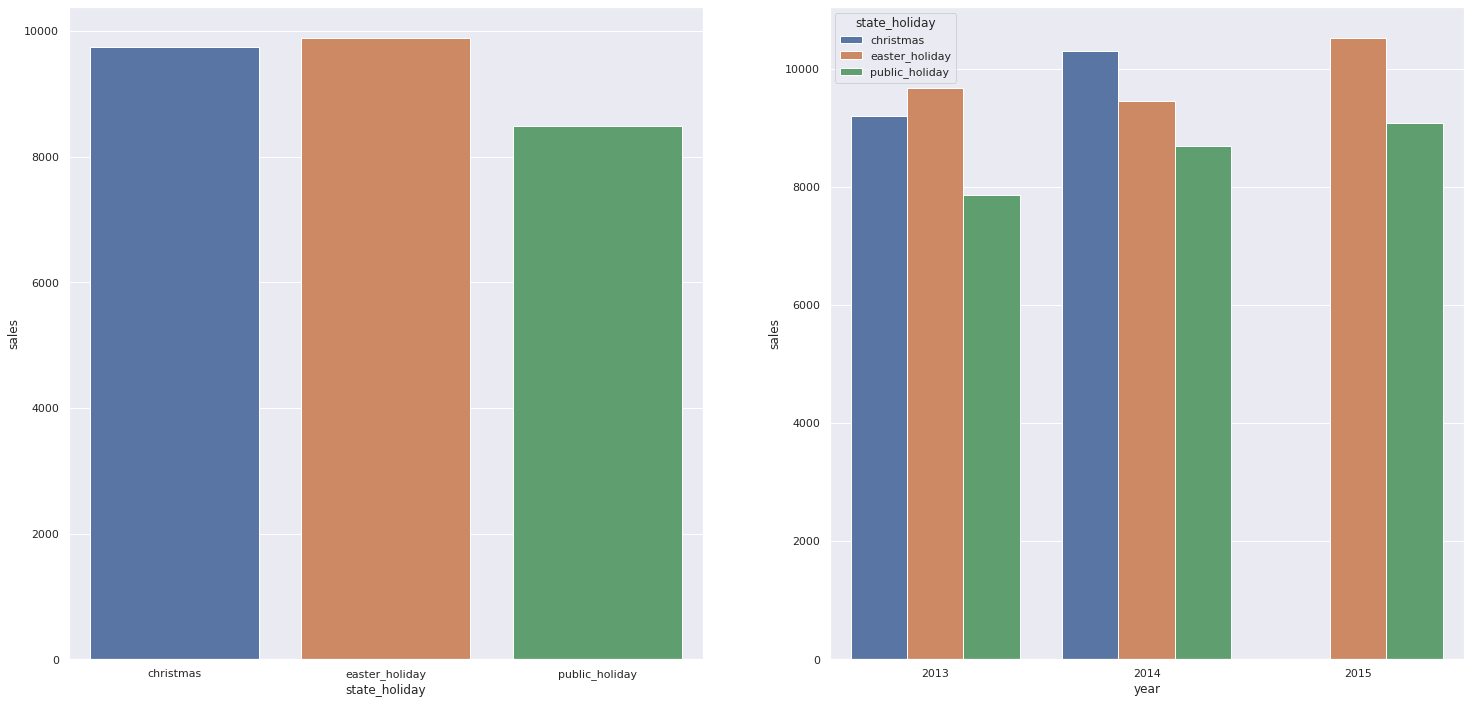

In [39]:
auxi7 = df4[df4['state_holiday'] != 'regular_day']
aux7 = auxi7[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()

auxil7 = auxi7[['state_holiday', 'sales']].groupby('state_holiday').count().reset_index()

aux7['sales'] = aux7['sales'] / auxil7['sales']

plt.subplot(1, 2, 1)
sns.barplot(x='state_holiday', y='sales', data=aux7);

auxili7 = auxi7[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
auxilia7 = auxi7[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).count().reset_index()
auxili7['sales'] = auxili7['sales'] / auxilia7['sales']

plt.subplot(1, 2, 2)
sns.barplot(x='year', y='sales', hue='state_holiday', data=auxili7);

### H8. Stores should increase sales along the years.
TRUE, however, we have little data, could be overfitting.

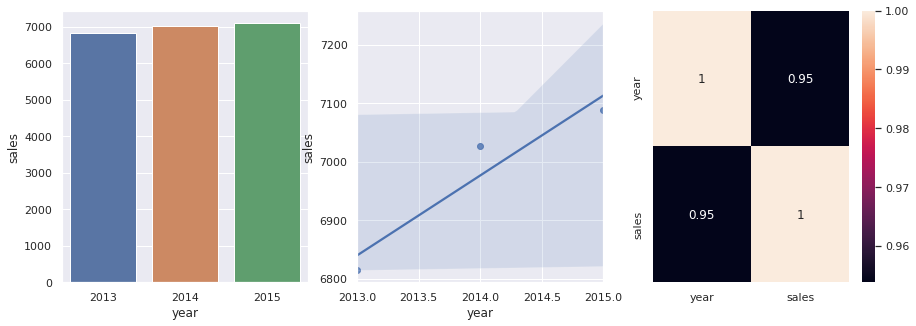

In [40]:
aux8 = df4[['year', 'sales']].groupby('year').sum().reset_index()
auxi8 = df4[['year', 'sales']].groupby('year').count().reset_index()
aux8['sales'] = aux8['sales'] / auxi8['sales']

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux8);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux8);

plt.subplot(1, 3, 3)
sns.heatmap(aux8.corr(method='pearson'), annot=True);

### H9. Stores should sell more in the end of the year.
TRUE: Especially the last 2 months of the year see a big spike in sales.

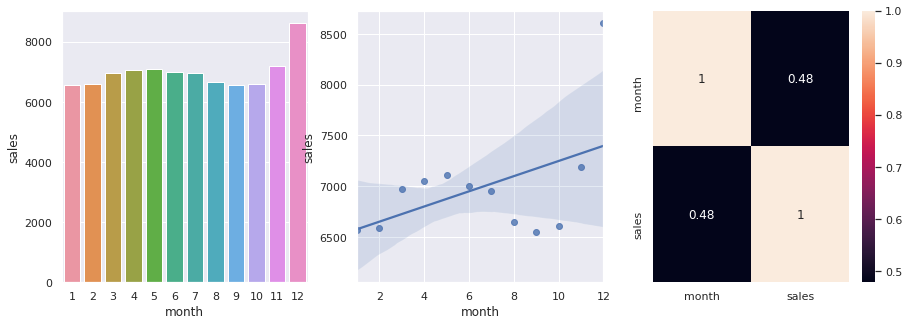

In [41]:
aux8 = df4[['month', 'sales']].groupby('month').sum().reset_index()
auxi8 = df4[['month', 'sales']].groupby('month').count().reset_index()
aux8['sales'] = aux8['sales'] / auxi8['sales']

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux8);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux8);

plt.subplot(1, 3, 3)
sns.heatmap(aux8.corr(method='pearson'), annot=True);

### H10. Stores should sell more after the 10th of each month.
FALSE

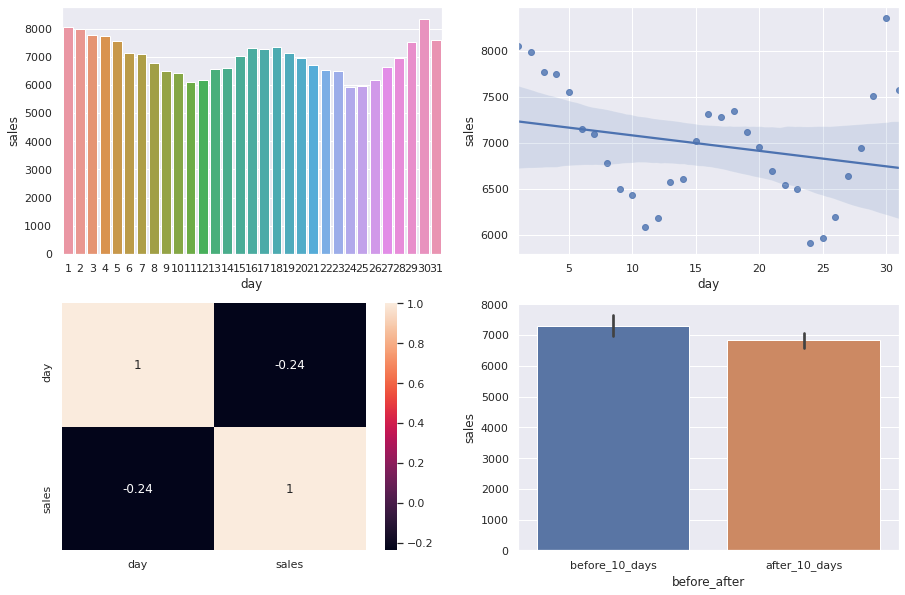

In [42]:
aux10 = df4[['day', 'sales']].groupby('day').sum().reset_index()
auxi10 = df4[['day', 'sales']].groupby('day').count().reset_index()
aux10['sales'] = aux10['sales'] / auxi10['sales']

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux10);
plt.xticks

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux10);

plt.subplot(2, 2, 3)
sns.heatmap(aux10.corr(method='pearson'), annot=True);

plt.subplot(2, 2, 4)
aux10['before_after'] = aux10['day'].apply(lambda x: 'before_10_days' if x<= 10 else 'after_10_days')
aux10[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data=aux10);

### H11. Stores should sell less in weekends.
TRUE, although the difference is not big.


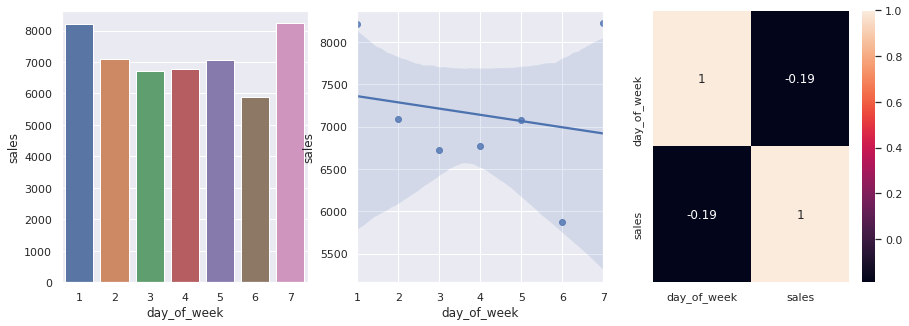

In [43]:
aux11 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
auxi11 = df4[['day_of_week', 'sales']].groupby('day_of_week').count().reset_index()
aux11['sales'] = aux11['sales'] / auxi11['sales']

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux11);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux11);

plt.subplot(1, 3, 3)
sns.heatmap(aux11.corr(method='pearson'), annot=True);

### H12. Stores should sell less in school holidays.
FALSE, sells more in almost every case, but not by much.

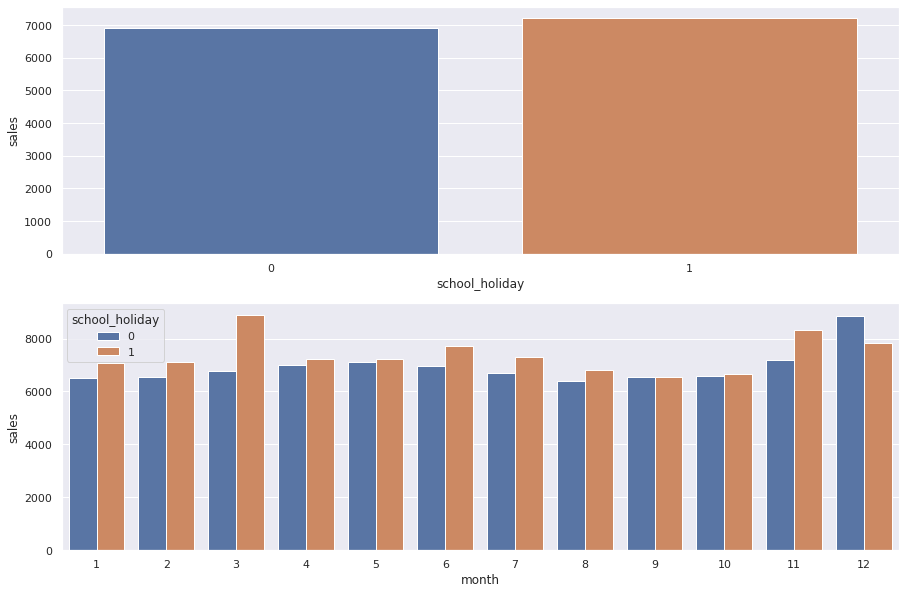

In [44]:
aux12 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
auxi12 = df4[['school_holiday', 'sales']].groupby('school_holiday').count().reset_index()
aux12['sales'] = aux12['sales'] / auxi12['sales']

plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux12);

plt.subplot(2, 1, 2)
aux12 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
auxi12 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).count().reset_index()
aux12['sales'] = aux12['sales'] / auxi12['sales']
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux12);


## 4.3 - Multivariate Analysis

### 4.3.1 - Numerical Attributes

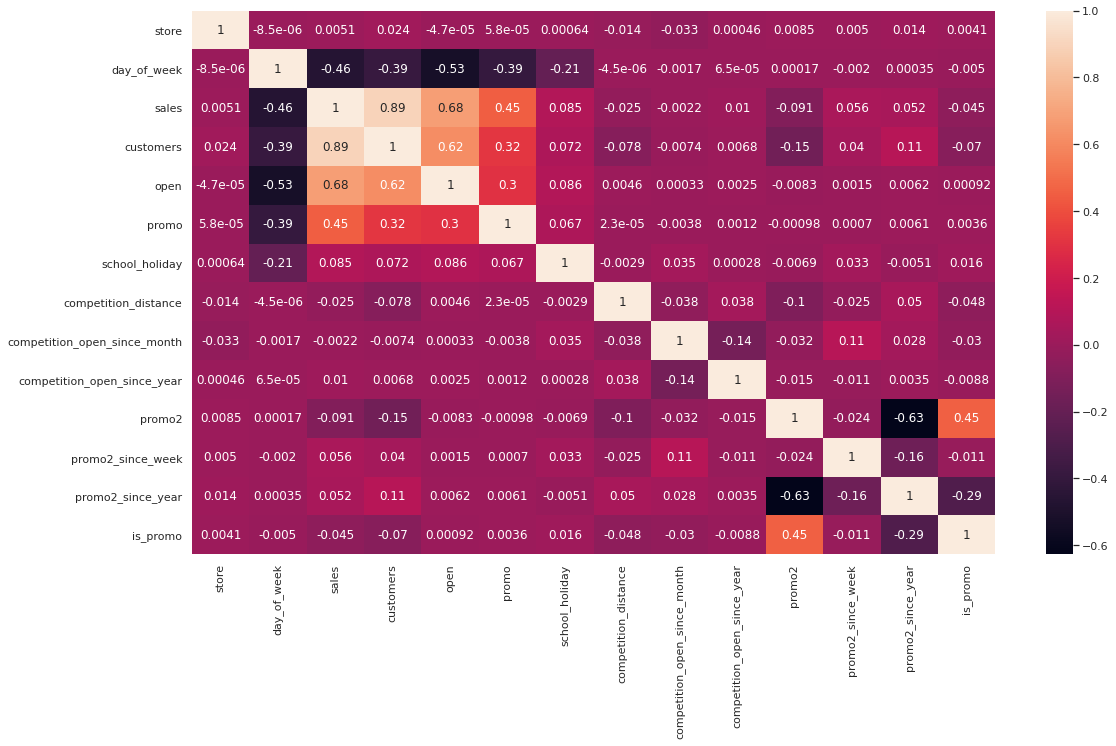

In [45]:
correlation = num_attr.corr(method='pearson')
plt.figure(figsize=(18, 10))
sns.heatmap(correlation, annot=True);

### 4.3.2 - Categorical Attributes

In [46]:
categorical = df4.select_dtypes(include='object')

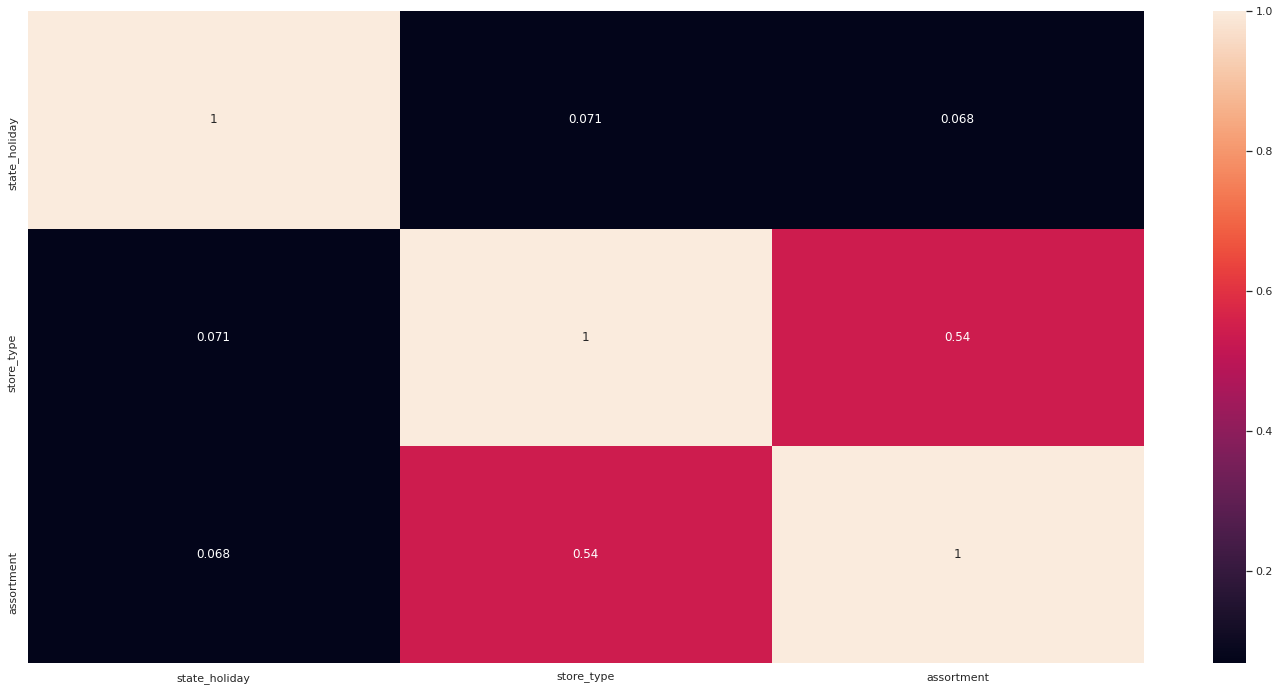

In [47]:
# Calculating Cramer's V
a1 = cramer_v(categorical['state_holiday'], categorical['state_holiday'])
a2 = cramer_v(categorical['state_holiday'], categorical['store_type'])
a3 = cramer_v(categorical['state_holiday'], categorical['assortment'])

a4 = cramer_v(categorical['store_type'], categorical['state_holiday'])
a5 = cramer_v(categorical['store_type'], categorical['store_type'])
a6 = cramer_v(categorical['store_type'], categorical['assortment'])

a7 = cramer_v(categorical['assortment'], categorical['state_holiday'])
a8 = cramer_v(categorical['assortment'], categorical['store_type'])
a9 = cramer_v(categorical['assortment'], categorical['assortment'])

# Resulting Dataset
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)

sns.heatmap(d, annot=True);

# 5.0 - DATA PREPARATION

In [48]:
df5 = df4.copy()

## 5.1 - Standardizing

In [49]:
# There are no notable normal-distributed variables.
# We will not use standardizing.

## 5.2 - Rescaling

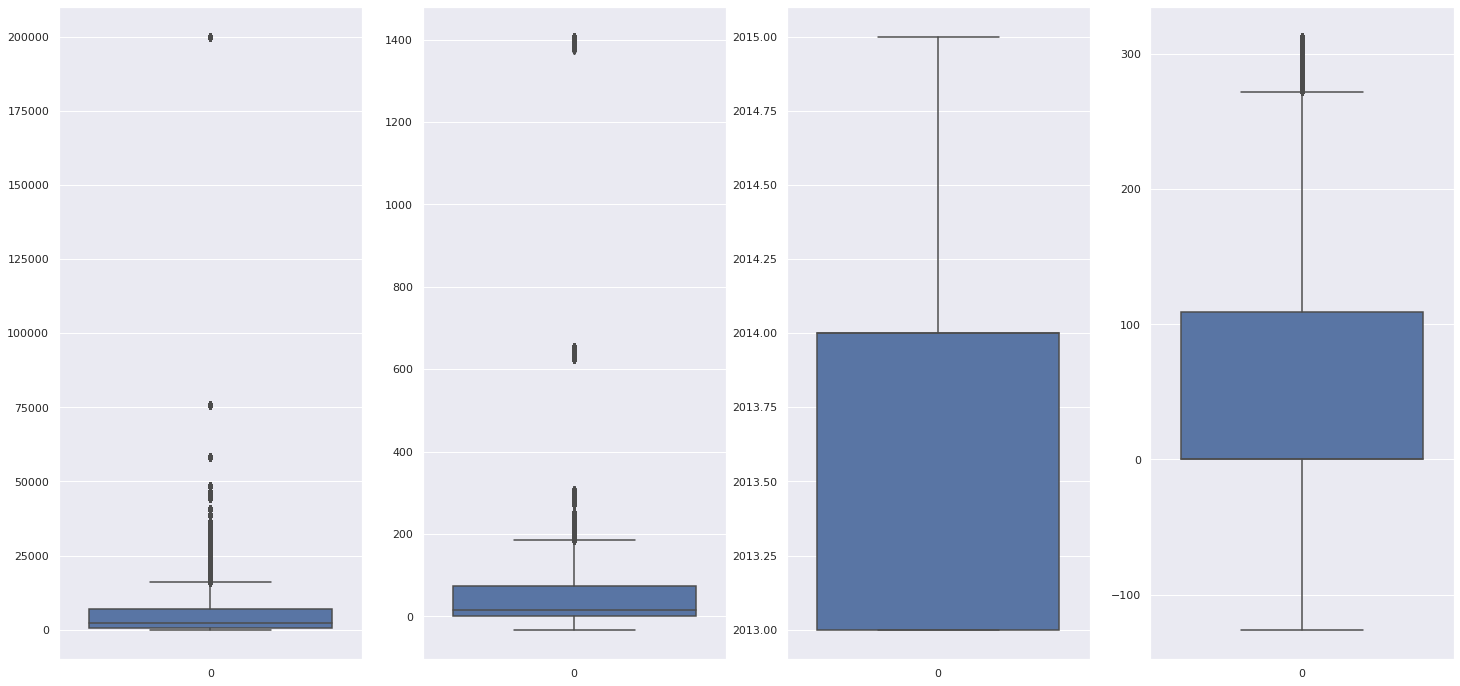

In [50]:
a = df5.select_dtypes(include=['int64', 'float64'])

plt.subplot(1, 4, 1)
sns.boxplot(data=df5['competition_distance']);

plt.subplot(1, 4, 2)
sns.boxplot(data=df5['competition_time_month']);

plt.subplot(1, 4, 3)
sns.boxplot(data=df5['year']);

plt.subplot(1, 4, 4)
sns.boxplot(data=df5['promo_time_week']);

In [51]:
# Since we see lots of outliers, we will use robust scaler.
rs = RobustScaler()

df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

# For the last 2, we will use min-max scaler.
mms = MinMaxScaler()

df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(rs, open('parameter/year_scaler.pkl', 'wb'))

df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl', 'wb'))

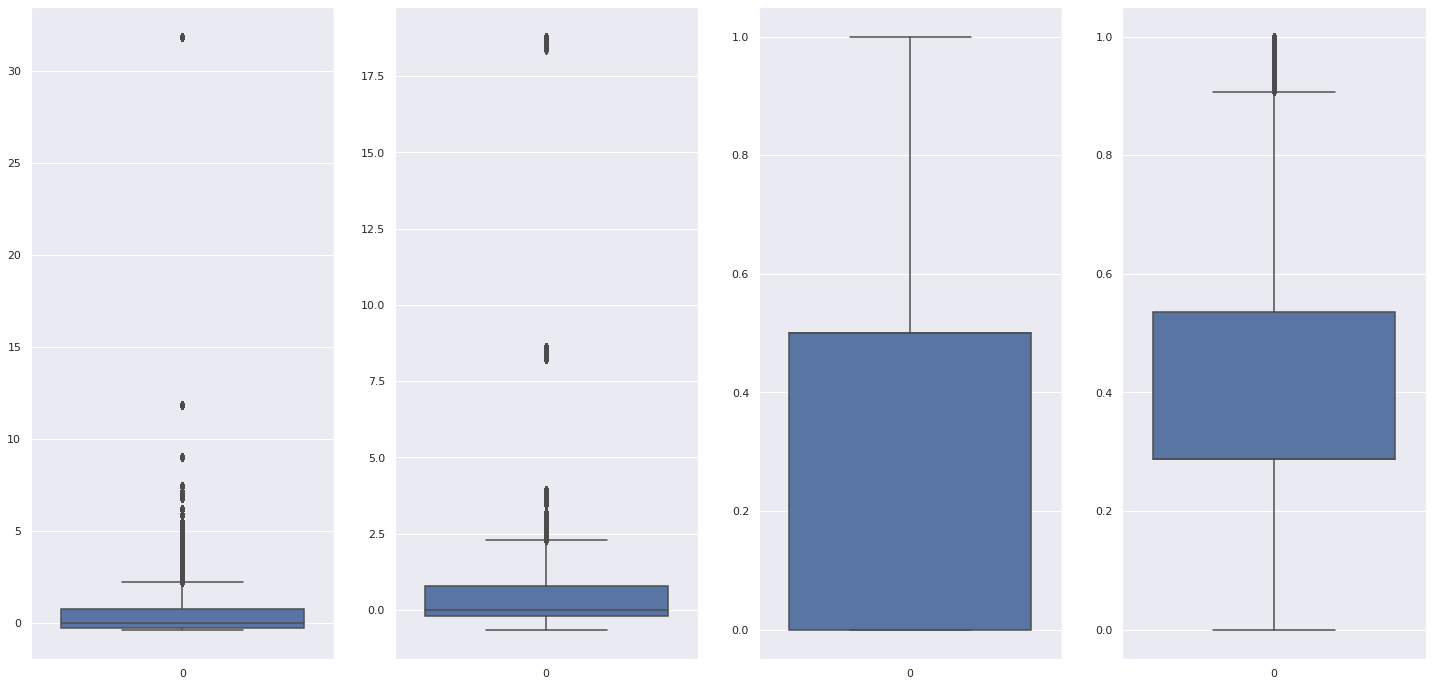

In [52]:
a = df5.select_dtypes(include=['int64', 'float64'])

plt.subplot(1, 4, 1)
sns.boxplot(data=df5['competition_distance']);

plt.subplot(1, 4, 2)
sns.boxplot(data=df5['competition_time_month']);

plt.subplot(1, 4, 3)
sns.boxplot(data=df5['year']);

plt.subplot(1, 4, 4)
sns.boxplot(data=df5['promo_time_week']);

## 5.3 - Transforming

### 5.3.1 - Encoding

In [53]:
# state_holiday - one hot
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type - label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))


# assortment - ordinal encoding
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

df5.sample(5)

store  day_of_week       date  sales  promo  school_holiday  store_type  assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year  is_promo  year  month  day  week_of_year year_week competition_since  competition_time_month promo_since  promo_time_week  state_holiday_christmas  state_holiday_easter_holiday  state_holiday_public_holiday  state_holiday_regular_day
251613    331            1 2014-12-15   9968      1               0           0           3             -0.267742                            12                         2014       1                 14               2015         0   0.5     12   15            51   2014-50        2014-12-01               -0.216216  2015-03-30         0.252847                        0                             0                             0                          1
168551    187            1 2015-03-02   8418      1               0           0           3              2.746774                             3                         2015       0                 10               2015         0   1.0      3    2            10   2015-09        2015-03-01               -0.216216  2015-03-02         0.287016                        0                             0                             0                          1
498537    918            5 2014-04-11   4800      0               0           0           3              2.641935                             4                         2015       0                 15               2014         0   0.5      4   11            15   2014-14        2015-04-01               -0.378378  2014-04-07         0.287016                        0                             0                             0                          1
195639    515            5 2015-02-06  11029      1               0           3           3              1.440323                             2                         2015       1                  9               2011         1   1.0      2    6             6   2015-05        2015-02-01               -0.216216  2011-02-21         0.756264                        0                             0                             0                          1
932239    885            1 2013-03-18   6243      1               0           0           1             -0.298387                            12                         2005       0                 12               2013         0   0.0      3   18            12   2013-11        2005-12-01                0.972973  2013-03-18         0.287016                        0                             0                             0                          1

### 5.3.2 - Nature Transforming

In [54]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * (np.pi / 12))))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * (np.pi / 12))))
                       
# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * (np.pi / 30))))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * (np.pi / 30))))
                                      
# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * (np.pi / 52))))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * (np.pi / 52))))

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * (np.pi / 7))))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * (np.pi / 7))))
                                                  
df5.sample(5)

store  day_of_week       date  sales  promo  school_holiday  store_type  assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year  is_promo  year  month  day  week_of_year year_week competition_since  competition_time_month promo_since  promo_time_week  state_holiday_christmas  state_holiday_easter_holiday  state_holiday_public_holiday  state_holiday_regular_day  month_sin  month_cos   day_sin   day_cos  week_of_year_sin  week_of_year_cos  day_of_week_sin  day_of_week_cos
199875    291            1 2015-02-02  12377      1               0           3           1             31.882258                             2                         2015       0                  6               2015         0   1.0      2    2             6   2015-05        2015-02-01               -0.216216  2015-02-02         0.287016                        0                             0                             0                          1   0.866025   0.500000  0.406737  0.913545          0.663123          0.748511         0.781831         0.623490
502166     87            1 2014-04-07   6369      0               0           0           1             -0.285484                            12                         2010       0                 15               2014         0   0.5      4    7            15   2014-14        2010-12-01                0.324324  2014-04-07         0.287016                        0                             0                             0                          1   0.866025  -0.500000  0.994522  0.104528          0.970942         -0.239316         0.781831         0.623490
752728    889            1 2013-08-26   5780      1               1           3           1              2.635484                            12                         2005       0                 35               2013         0   0.0      8   26            35   2013-34        2005-12-01                1.054054  2013-08-26         0.287016                        0                             0                             0                          1  -0.866025  -0.500000 -0.743145  0.669131         -0.885456         -0.464723         0.781831         0.623490
73770     181            2 2015-05-26   5882      0               1           0           1              1.658065                             3                         2013       1                 14               2011         0   1.0      5   26            22   2015-21        2013-03-01                0.148649  2011-03-28         0.781321                        0                             0                             0                          1   0.500000  -0.866025 -0.743145  0.669131          0.464723         -0.885456         0.974928        -0.222521
774125   1101            3 2013-08-07   8731      0               0           3           3              0.279032                             9                         2012       0                 32               2013         0   0.0      8    7            32   2013-31        2012-09-01               -0.067568  2013-08-05         0.287016                        0                             0                             0                          1  -0.866025  -0.500000  0.994522  0.104528         -0.663123         -0.748511         0.433884        -0.900969

### 5.3.3 - Response Variable Transforming

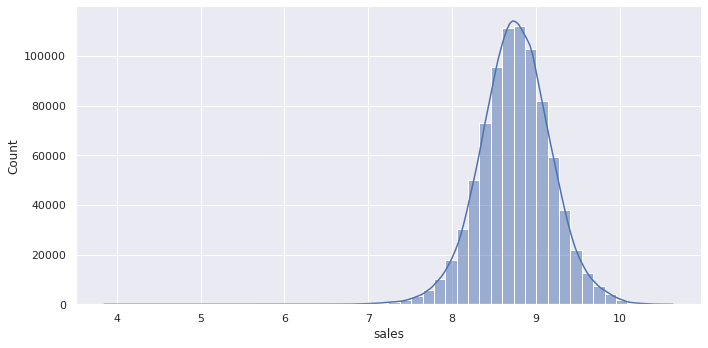

In [55]:
df5['sales'] = np.log1p(df5['sales'])

sns.displot(df5['sales'], kde=True, aspect=2, bins=50);

# 6.0 - FEATURE SELECTION

In [56]:
df6 = df5.copy()

## 6.1 - Splitting dataframe into training and test sets

In [57]:
df6.head()

store  day_of_week       date     sales  promo  school_holiday  store_type  assortment  competition_distance  competition_open_since_month  competition_open_since_year  promo2  promo2_since_week  promo2_since_year  is_promo  year  month  day  week_of_year year_week competition_since  competition_time_month promo_since  promo_time_week  state_holiday_christmas  state_holiday_easter_holiday  state_holiday_public_holiday  state_holiday_regular_day  month_sin  month_cos   day_sin   day_cos  week_of_year_sin  week_of_year_cos  day_of_week_sin  day_of_week_cos
0      1            5 2015-07-31  8.568646      1               1           2           1             -0.170968                             9                         2008       0                 31               2015         0   1.0      7   31            31   2015-30        2008-09-01                0.918919  2015-07-27         0.287016                        0                             0                             0                          1       -0.5  -0.866025  0.207912  0.978148         -0.568065         -0.822984        -0.974928        -0.222521
1      2            5 2015-07-31  8.710290      1               1           0           1             -0.283871                            11                         2007       1                 13               2010         1   1.0      7   31            31   2015-30        2007-11-01                1.054054  2010-03-22         0.922551                        0                             0                             0                          1       -0.5  -0.866025  0.207912  0.978148         -0.568065         -0.822984        -0.974928        -0.222521
2      3            5 2015-07-31  9.025816      1               1           0           1              1.903226                            12                         2006       1                 14               2011         1   1.0      7   31            31   2015-30        2006-12-01                1.202703  2011-03-28         0.801822                        0                             0                             0                          1       -0.5  -0.866025  0.207912  0.978148         -0.568065         -0.822984        -0.974928        -0.222521
3      4            5 2015-07-31  9.546527      1               1           2           3             -0.275806                             9                         2009       0                 31               2015         0   1.0      7   31            31   2015-30        2009-09-01                0.743243  2015-07-27         0.287016                        0                             0                             0                          1       -0.5  -0.866025  0.207912  0.978148         -0.568065         -0.822984        -0.974928        -0.222521
4      5            5 2015-07-31  8.481151      1               1           0           1              4.448387                             4                         2015       0                 31               2015         0   1.0      7   31            31   2015-30        2015-04-01               -0.162162  2015-07-27         0.287016                        0                             0                             0                          1       -0.5  -0.866025  0.207912  0.978148         -0.568065         -0.822984        -0.974928        -0.222521

In [58]:
cols_drop = ['month', 'day', 'week_of_year', 'day_of_week', 'promo_since', 'competition_since', 'year_week']

df6 = df6.drop(cols_drop, axis=1)

In [59]:
# grabbing the last 6 weeks of out dataset.
d = df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6 * 7)

# train dataset.
X_train = df6[df6['date'] < d]
Y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= d]
Y_test = X_test['sales']

# checking dates
print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))
print('')
print('Test Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 - Boruta as Feature Selector

In [60]:
# training and test dataset
X_train_n = X_train.drop(['date', 'sales'], axis=1).values
Y_train_n = Y_train.values.ravel()

# # defining Random Forest Regressor
# rf = RandomForestRegressor(n_jobs=-1)

# # defining Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, Y_train_n)

In [61]:
# cols_selected = boruta.support_.tolist()

# # best features
# X_train_fs = X_train.drop(['date', 'sales'], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # not selected boruta
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3 - Manual Feature Selection

In [62]:
# Boruta is a time consuming algorithm.
# We will save this value so we don't have to run it again.
# Also, we will add some columns.
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'month_cos',
                        'day_sin',
                        'week_of_year_cos',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'day_cos']

cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'month_cos',
                        'day_sin',
                        'week_of_year_sin',
                        'week_of_year_cos',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'day_cos']

# adding the final features
feats = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feats)

# 7.0 - MACHINE LEARNING MODELING

In [63]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

## 7.1 - Average Model

In [64]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')

yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error('Average Model', np.expm1(Y_test), np.expm1(yhat_baseline))
baseline_result

Model Name          MAE      MAPE         RMSE
0  Average Model  1354.800353  0.455051  1835.135542

## 7.2 - Linear Regression Model

In [65]:
# model
lr = LinearRegression().fit(x_train, Y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))
lr_result

Model Name          MAE      MAPE        RMSE
0  Linear Regression  1870.265338  0.292297  2678.61434

## 7.3 - Linear Regression Regularized Model

In [66]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, Y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
lrr_result

Model Name          MAE      MAPE         RMSE
0      Lasso  1891.571731  0.289606  2742.552393

## 7.4 - Random Forest Regressor

In [67]:
# model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, Y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest', np.expm1(Y_test), np.expm1(yhat_rf))
rf_result

Model Name         MAE      MAPE         RMSE
0  Random Forest  679.503902  0.099948  1009.604375

## 7.5 - XGBoost Regressor

In [68]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=1000,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, Y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost', np.expm1(Y_test), np.expm1(yhat_xgb))
xgb_result

Model Name         MAE      MAPE         RMSE
0    XGBoost  886.675321  0.127862  1316.539757

## 7.6 - Comparing Performance of Models

In [69]:
modeling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modeling_result.sort_values('RMSE')

Model Name          MAE      MAPE         RMSE
0      Random Forest   679.503902  0.099948  1009.604375
0            XGBoost   886.675321  0.127862  1316.539757
0      Average Model  1354.800353  0.455051  1835.135542
0  Linear Regression  1870.265338  0.292297  2678.614340
0              Lasso  1891.571731  0.289606  2742.552393

## 7.7 - Cross Validation

In [70]:
x_training = X_train[cols_selected_boruta_full]

In [71]:
# models = [['Linear Regression', lr],
#           ['Linear Regression Regularized', lrr],
#           ['Random Forest Regressor', rf],
#           ['XGBoost Regressor', model_xgb]]

# results = []

# for i in models:
#     results.append(cross_validation(x_training, 6, i[0], i[1], verbose=True))
    
# cv_result = pd.concat(results)
# cv_result

# 8.0 - HYPERPARAMETER FINE TUNING

## 8.1 - Random Search

In [72]:
param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight':[3, 8, 15]}

MAX_EVAL = 10

In [73]:
# final_result = pd.DataFrame()
# used_param = []

# for i in range(MAX_EVAL):
#     # choose values for parameters randomly
#     # making sure we don't repeat parameter sets
#     while True:
#         hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
        
#         if hp in used_param:
#             continue
            
#         else:
#             used_param.append(hp)
#             break
            
#     print(hp)
    
#     # model
#     model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
#                                  n_estimators=hp['n_estimators'],
#                                  eta=hp['eta'],
#                                  max_depth=hp['max_depth'],
#                                  subsample=hp['subsample'],
#                                  colsample_bytree=hp['subsample'],
#                                  min_child_weight=hp['min_child_weight'])

#     # performance
#     xgb_result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=False)
#     display(xgb_result)
#     final_result = pd.concat([final_result, xgb_result])
                             
# final_result

## 8.2 - Final Model

In [77]:
param = {'n_estimators': 1500, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 15}

model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                                   n_estimators=param['n_estimators'],
                                   eta=param['eta'],
                                   max_depth=param['max_depth'],
                                   subsample=param['subsample'],
                                   colsample_bytree=param['subsample'],
                                   min_child_weight=param['min_child_weight']).fit(x_train, Y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
# xgb_result_cv_tuned = cross_validation(x_training, 6, 'XGBoost Regressor', model_xgb_tuned, verbose=False)

# xgb_result_cv_tuned

# 9.0 - INTERPRETING THE ERROR

In [78]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 - Business Performance

In [79]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# possibilities
df92['worst_scenario'] = df92['predictions'] - 6 * df92['MAE']
df92['best_scenario'] = df92['predictions'] + 6 * df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [80]:
df92.sample(5)

store    predictions  worst_scenario  best_scenario          MAE      MAPE
357    358  368649.812500   364920.495064  372379.129936   621.552906  0.064709
602    603  261418.859375   258484.935547  264352.783203   488.987305  0.069974
214    215  232658.937500   228690.346944  236627.528056   661.431759  0.103543
769    770  184909.015625   181858.178539  187959.852711   508.472848  0.117068
415    416  373127.312500   365354.106868  380900.518132  1295.534272  0.111816

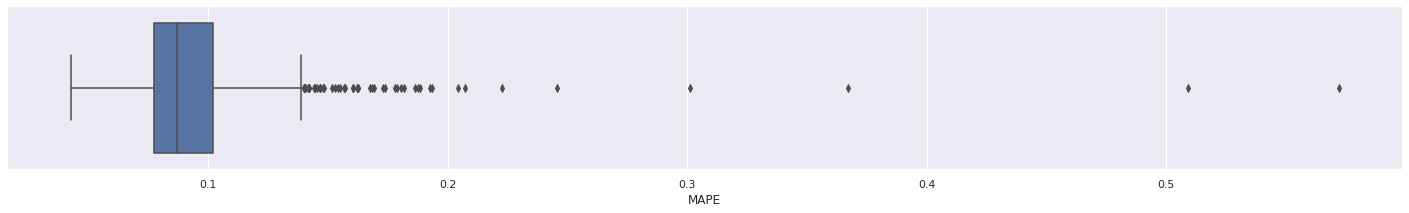

In [81]:
plt.figure(figsize=(25, 3))
sns.boxplot(x='MAPE', data=df92);

## 9.2 - Total Performance

In [82]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'Index': 'Scenarios', 0: 'Values'})
df93['Values'] = df93['Values'].map('EUR {:,.2f}'.format)

df93

index              Values
0     predictions  EUR 283,547,072.00
1  worst_scenario  EUR 279,230,775.62
2   best_scenario  EUR 287,863,396.15

## 9.3 - Machine Learning Performance

In [83]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

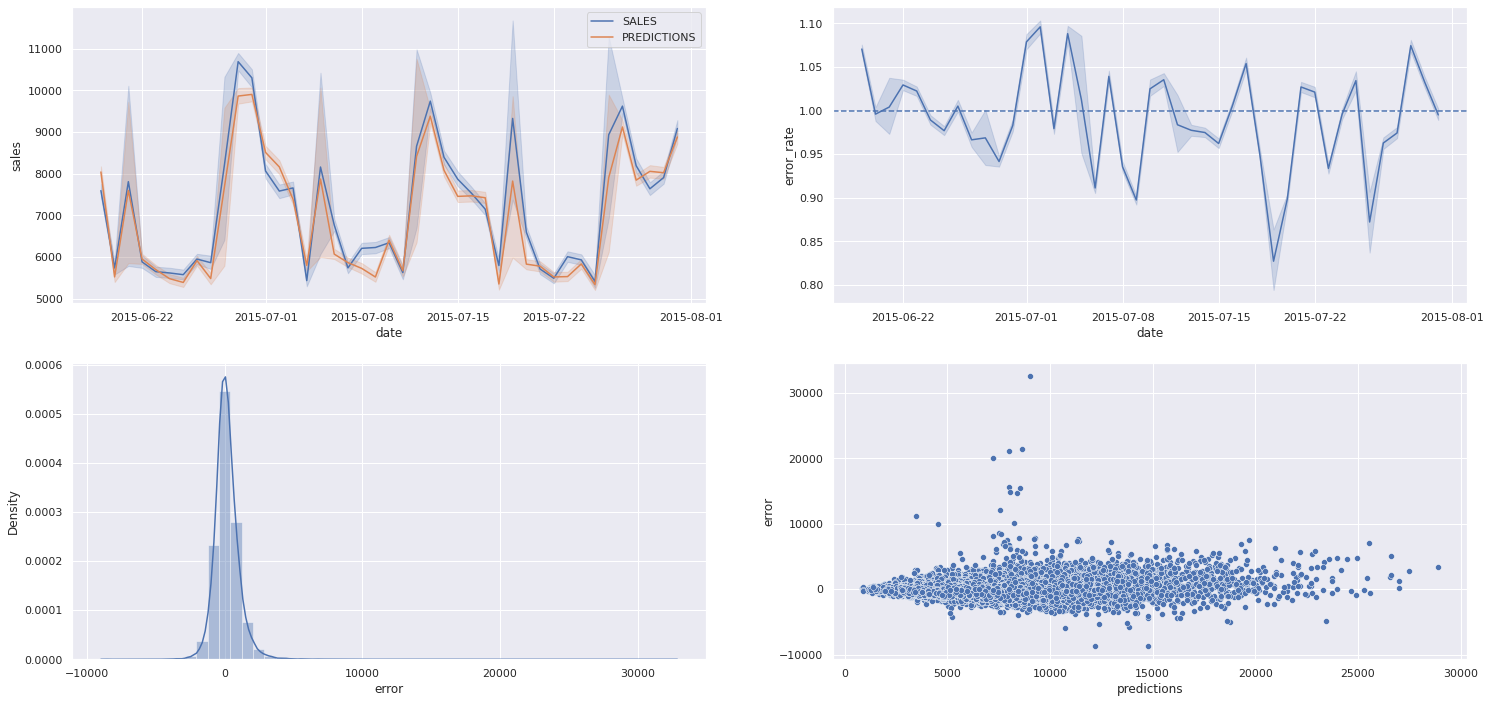

In [84]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES');
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS');

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9);
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error']);

# 10.0 - MODEL DEPLOY

In [ ]:
# saving trained model
pickle.dump(model_xgb_tuned, open('model/model_rossmann.pkl', 'wb'))

## 10.1 - Rossmann Class

In [ ]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):
    def __init__(self):
        self.home_path = '/home/augusto/repos/RossmannProject/'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
    
    
    def data_cleaning(self, df1):
        
        ## 1.1 - Renaming Columns

        cols_old = [ 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval' ]

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        df1.columns = cols_new


        df1['date'] = pd.to_datetime(df1['date']) 

        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )

        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

        map_month = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

        df1['promo_interval'].fillna( 0, inplace=True )

        df1['map_month'] = df1['date'].dt.month.map( map_month )

        df1['is_promo'] = df1[['map_month', 'promo_interval']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['map_month'] in x['promo_interval'].split( ',' ) else 0, axis=1 ) 

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

        df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
        df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )
        
        return df1

    
    def feature_engineering(self, df2):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

        # change to better values:
        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        ## 3.1 - Rows Filtering

        df2 = df2[(df2['open'] != 0)]

        ## 3.2 - Column Selection

        cols_drop = ['open', 'promo_interval', 'map_month']
        df2 = df2.drop(cols_drop, axis=1)
        
        return df2
    
    
    def data_preparation(self, df5):

        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)

        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        ### 5.3.1 - Encoding

        # state_holiday - one hot
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - label encoding
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])


        # assortment - ordinal encoding
        assortment_dict = {'basic': 1,
                           'extra': 2,
                           'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.2 - Nature Transforming

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * (np.pi / 12))))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * (np.pi / 12))))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * (np.pi / 30))))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * (np.pi / 30))))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * (np.pi / 52))))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * (np.pi / 52))))

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * (np.pi / 7))))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * (np.pi / 7))))
        
        cols_selected = ['store','promo','store_type','assortment','competition_distance',
                         'competition_open_since_month','competition_open_since_year','promo2',
                         'promo2_since_week','promo2_since_year','competition_time_month',
                         'promo_time_week','month_cos','day_sin','week_of_year_sin',
                         'week_of_year_cos','day_of_week_sin','day_of_week_cos','day_cos']
        
        return df5[cols_selected]
    
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')        

## 10.2 - API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = pickle.load(open('/home/augusto/repos/RossmannProject/model/model_rossmann.pkl', 'rb'))

app = Flask(__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json:
        if isinstance(test_json, dict): # one line
            test_raw = pd.DataFrame(test_json, index=[0])
        
        else: # multiple lines
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        pipeline = Rossmann()
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature_engineering
        df2 = pipeline.feature_engineering(df1)
        
        # data preparation
        df3 = pipeline.data_preparation(df2)
        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else:
        return Response('{}', status=200, mimetype='applcation/json')

if __name__ == '__main__':
    app.run('0.0.0.0')

## 10.3 - API Tester

In [ ]:
import requests

# loading test dataset
df10 = pd.read_csv('/home/augusto/repos/RossmannProject/data/test.csv')

# merge test dataset and store
df_test = pd.merge(df10, df_store_raw, how = 'left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([20, 1, 100])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[-df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

# convert df to json
data = json.dumps(df_test.to_dict(orient='records'))

# API Call

# url = 'http://192.168.1.3:5000/rossmann/predict'
url = 'https://sales-prediction-rossmann.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    print('Store Number {} will sell EUR {:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction']))